In [1]:
# Import modules and packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import tensorflow as tf

from datetime import datetime
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.losses import Huber, MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

from functools import reduce

%matplotlib inline

In [2]:
def retrieve_datasets(icsa_shift):
    """
    Importing data files-eia barrels, eia pricing and icsa unemployment (weekly) claims. 
    """
    eia_df = pd.read_csv("data/all_eia_stock_sheet_latest.csv",header=0,
                                infer_datetime_format=True, delimiter=';',parse_dates=['Date'], index_col=['Date']) 	#Date 2	Aug 27, 1982
    
    eia_pricing_df = pd.read_csv('data/eia_pricing_latest.csv',header=0,
                                infer_datetime_format=True, delimiter=';',parse_dates=['Date'], index_col=['Date']) 	#Date 2	Aug 27, 1982
    #eia_pricing_df = eia_pricing_df.shift(0)
    
    icsa_df = pd.read_csv('data/ICSA_current.csv',header=0,
                          infer_datetime_format=True, delimiter=',',
                          parse_dates=['DATE'] ,index_col=['DATE'])
   
    #reduce scale to per barrel pricing
    #eia_df = eia_df.div(10000).round(5)
    #icsa_df = icsa_df.div(10000).round(5)


    #shift back one day to match and pair with s&p dates that line up with EIA (eia_df) dates
    icsa_df.index = icsa_df.index + pd.Timedelta(days=-1)
    
    #rename index and shift back x periods as unemployement data *should* be indicator later...periods = weeks
    icsa_df.index = icsa_df.index.rename('Date')
    icsa_df = icsa_df.shift(periods=icsa_shift)
      
    return (eia_df, eia_pricing_df, icsa_df)


def combine_datasets(datasets, start_date, end_date):
    """
    We expect an list of dataframes to iterate over and create a final combined df
    Expected column key for the join is 'Date'
    """


    df_list = list(range(0, len(datasets)))
    dataset_list = list()
    for i in df_list:
        dataset_list.append(datasets[i])
    #cols = ['WCESTUS1', 'WCESTP21', 'WCRSTUS1', 'WCESTP31', 'WCSSTUS1','WTTSTUS1','ICSA','RCLC1']  #columns to use in train/val/predict       
    #cols = ['WCESTUS1','WCESTUS1','WCESTP21','WTTSTUS1','ICSA','RCLC1']  #columns to use in train/val/predict       
    cols = ['WCESTUS1','WCRSTUS1','WCESTP11','WCESTP21','W_EPC0_SAX_YCUOK_MBBL','WCESTP31','WCESTP41','WCESTP51','W_EPC0_SKA_NUS_MBBL','WCSSTUS1']
    combo_df = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                                   how='inner'), dataset_list)
    combo_df = combo_df.sort_index(ascending=True)
    combo_df = combo_df[cols] #'WCSSTUS1',
    combo_df.dropna(inplace=True) #just in case, drop non numbers
    
    #only use data from 2010 as this is beginning of some of the columns of data in eia barrels data
    combo_df = combo_df[start_date:end_date]

    return combo_df

#fetch all the data from .csv then combine them into one single df on 'Date' index
datasets   = retrieve_datasets(4)
start_date = '2010-01-01'
end_date   = '2020-12-31'
combo_df   = combine_datasets(datasets, start_date, end_date)
cols       = list(combo_df.columns)

dataset_train = combo_df

print(f'TAIL: {dataset_train.tail()}')
#columns to be used in training/prediction


n_future = 1   # Number of weeks we want to predict into the future
n_past   = 4   # Number of past weeks we want to use to predict the future

#get list of dates for plotting from the index (Date) column
datelist_train = list(dataset_train.index)


print(f'Training set shape: {dataset_train.shape}')
print(f'All timestamps:    {len(datelist_train)}')
print(cols)

TAIL:             WCESTUS1  WCRSTUS1  WCESTP11  WCESTP21  W_EPC0_SAX_YCUOK_MBBL  \
Date                                                                        
2020-11-13    489475   1127776   10274.0  148156.0                61613.0   
2020-11-20    488721   1126911   10131.0  146251.0                59892.0   
2020-11-27    488042   1126232   10489.0  146859.0                59575.0   
2020-12-04    503231   1141316   10611.0  146740.0                58211.0   
2020-12-11    500096   1138182   11553.0  146377.0                58409.0   

            WCESTP31  WCESTP41  WCESTP51  W_EPC0_SKA_NUS_MBBL  WCSSTUS1  
Date                                                                     
2020-11-13  260801.0   24504.0   45740.0               2805.0    638301  
2020-11-20  262822.0   24272.0   45244.0               2522.0    638190  
2020-11-27  262170.0   23964.0   44561.0               4172.0    638190  
2020-12-04  273963.0   24165.0   47753.0               2685.0    638085  
2020-12-11

In [3]:

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print(f'Shape of training set == {training_set.shape}.')


Shape of training set == (550, 10).


In [4]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

np.info(training_set_scaled)


class:  ndarray
shape:  (550, 10)
strides:  (8, 4400)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x4d4b5d0
byteorder:  little
byteswap:  False
type: float64


In [5]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []
#pred_X  = []

#n_future = 1   # Number of weeks we want to predict into the future
#n_past = 4    # Number of past weeks we want to use to predict the future
#dataset_train.index[567]+ pd.Timedelta(days=+7)

#future_dates

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(f'X_train shape == {format(X_train.shape)}')
print(f'y_train shape == {format(y_train.shape)}')

X_train shape == (546, 4, 10)
y_train shape == (546, 1)


<h4>Create a model & Training</h4>

In [6]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(units=1, activation='relu'))

# Compiling the Neural Network
#model.compile(optimizer = Adam(learning_rate=0.001), loss=Huber())

<h3>Start training</h3>

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>


In [7]:
%%time
MAX_EPOCHS = 30
model_name = f'{start_date}_to_{end_date}_past-{n_past}_future-{n_future}_final_weights.h5'
#es = EarlyStopping(monitor='val_loss', mode='auto',min_delta=1e-7, patience=10, verbose=0)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0)
mcp = ModelCheckpoint(filepath='models/mv_latest_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='max', min_delta=1e-5)

model.compile(optimizer = Adam(learning_rate=0.001), loss=Huber())
history = model.fit(X_train, y_train,shuffle=False, validation_split=0.03,verbose=0,batch_size=8, epochs=MAX_EPOCHS,callbacks=[rlr, mcp, early_stopping])

print(np.mean(history.history["val_loss"]))

0.025428451065506254
CPU times: user 1min 6s, sys: 6.38 s, total: 1min 12s
Wall time: 20.5 s


In [8]:
if np.mean(history.history["val_loss"]) < 0.05: #model seems decent enough, let's re-train w/out any validation split 
    print(f'Model performance on initial training was good ==> {np.mean(history.history["val_loss"])}.\nSaving model {model_name}! :)')
    from keras import backend as K 
    K.clear_session()
    model.compile(optimizer = Adam(learning_rate=0.001), loss=Huber())
    model.fit(X_train, y_train,shuffle=False, verbose=0,batch_size=4, epochs=MAX_EPOCHS)
    model.save(f'models/{model_name}')
else:
    print(f'Model performance was poor ==> {np.mean(history.history["val_loss"])}.\nNot saving model :(')

Model performance on initial training was good ==> 0.025428451065506254.
Saving model 2010-01-01_to_2020-12-31_past-4_future-1_final_weights.h5! :)


In [9]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='7d').tolist()

#datelist_future = datelist_train[len(datelist_train)-n_future:]


print(datelist_future,n_future)
#print((datelist_train[-1]))
'''
Remember, we have datelist_train from begining.
'''
# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())


print(type(datelist_future))
print(datelist_future)

[Timestamp('2020-12-11 00:00:00', freq='7D')] 1
<class 'list'>
[Timestamp('2020-12-11 00:00:00', freq='7D')]


In [10]:
# Perform predictions
#print(-n_future,n_past,X_train[-n_future])
predictions_future = model.predict(X_train[-n_future:])
#print(f'X:{len(X_train)-4}') #...\n{X_train[len(X_train)-4:]}')
predictions_train = model.predict(X_train[n_past:])
#print(f'initial shape: {predictions_future.shape}')
#print(np.info(predictions_future))
#print('------------------')
#print(np.info(predictions_train))
#print('------------------')
#print(predictions_future)
#print('------------------')
#print(predictions_future.reshape(n_future,1))
predictions_future = predictions_future.reshape(n_future,1)
predictions_train = predictions_train.reshape(len(predictions_train),1)


In [11]:
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

print(y_pred_train.shape)
print(y_pred_future.shape)

(542, 1)
(1, 1)


In [12]:
# Inverse the predictions to original measurements
# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['WCESTUS1']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['WCESTUS1']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN,PREDICTIONS_FUTURE


PREDICTIONS_FUTURE.index = PREDICTIONS_FUTURE.index + pd.DateOffset(days=7) #timedelta(days=7)
print(PREDICTIONS_FUTURE)


                WCESTUS1
2020-12-18  501868.21875


<h3>Visualize the Predictions</h3>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


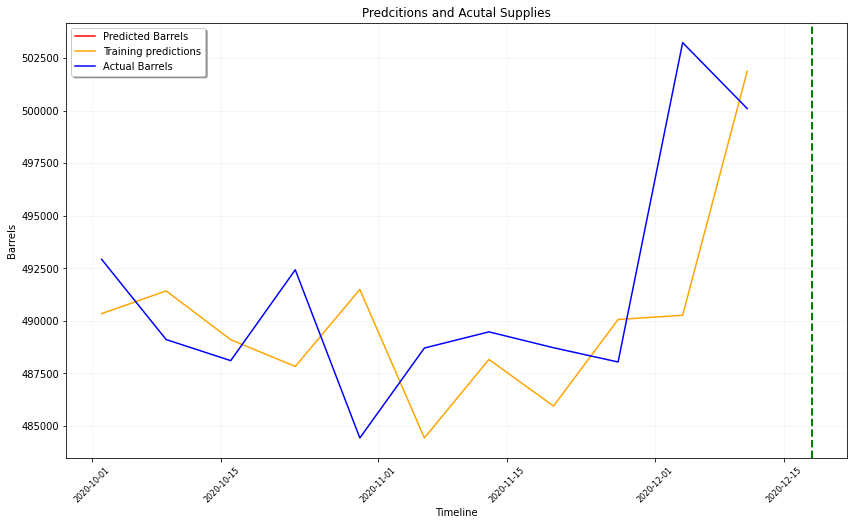

2020-12-18    501868.21875
Name: WCESTUS1, dtype: float32


In [13]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-10-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['WCESTUS1'], color='r', label='Predicted Barrels')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['WCESTUS1'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['WCESTUS1'], color='b', label='Actual Barrels')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.2)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Supplies', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Barrels', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

print(PREDICTIONS_FUTURE['WCESTUS1'])